## Описание проекта

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 

import matplotlib.pyplot as plt
from plotly import express as ex 
from plotly.offline import init_notebook_mode, iplot

import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

In [21]:
data = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.sort_index(inplace=True)

print('Начало:', data.index[0])
print('Конец:', data.index[-1])

print("Монотонный ли ряд:", data.index.is_monotonic)

Начало: 2018-03-01 00:00:00
Конец: 2018-08-31 23:50:00
Монотонный ли ряд: True


In [5]:
data.isna().sum()

num_orders    0
dtype: int64

> Данные собраны за каждые 10 минут с 1 марта 2018 года по 31 августа 2018 года. В данных нет пропусков, ряд монотонный.

## Анализ данных
Кратко изучим данные: 
1. Проверим распределние заказов в течение дня и недели
2. Посмотрим на наличие сезонности и тренда - проерим стационарность ряда
3. Узнаем, заисят ли данные друг от друга - построим функцию автокорреляции

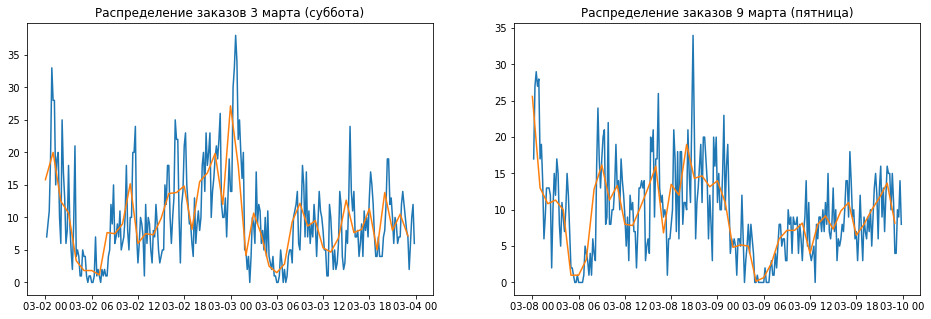

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
march3 = data[(data.index > '2018-03-02') & (data.index < '2018-03-04')]
march9 = data[(data.index < '2018-03-10') & (data.index > '2018-03-8')]


ax1.plot(march3)
for_hour1 = march3.resample('1H').mean()
ax1.plot(for_hour1)
ax1.set_title('Распределение заказов 3 марта (суббота)')
ax2.plot(march9)
for_hour2 = march9.resample('1H').mean()
ax2.plot(for_hour2)
ax2.set_title('Распределение заказов 9 марта (пятница)')
plt.show()

Больше всего заказов обычно наблюдается около полуночи, а также есть утренний пик в 8-9 утра. Ночью пик в будний день выше, тогда как в выходной наблюдается больше заказов утром. Визуально общее число заказов не отличается. Выводы сделаны по графикам, составленным по конкретным дням, поэтому,
чтобы проверить полученные результаты, проанализируем весь набор данных:

In [7]:
data['date'] = data.index
data['hour'] = data['date'].dt.hour
data['dw'] = data['date'].dt.day_name()

In [8]:
fig = ex.box(data, x="hour", y="num_orders", title = 'Распределение заказов по часам')

fig.add_hline(y=data.num_orders.mean(), line_width=2, line_dash="dash", line_color="green")
iplot(fig, show_link = False)

In [9]:
fig = ex.box(data, x="dw", y="num_orders", title = 'Распределение заказов по дням недели')

fig.add_hline(y=data.num_orders.mean(), line_width=2, line_dash="dash", line_color="green")
iplot(fig, show_link = False)

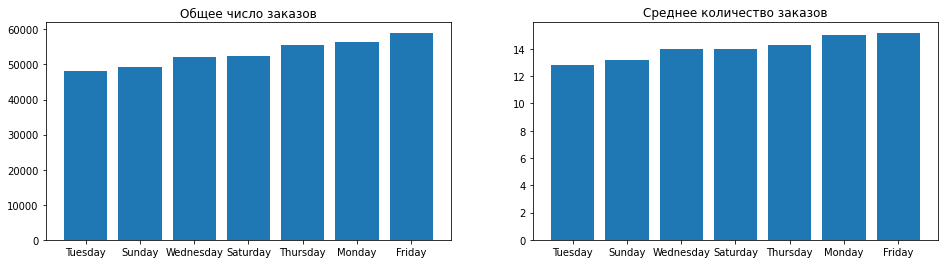

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
summa = data.groupby('dw')['num_orders'].sum().sort_values()
mean = data.groupby('dw')['num_orders'].mean().sort_values()


ax1.bar(summa.index, summa)


ax1.set_title('Общее число заказов')
ax2.bar(mean.index, mean)

ax2.set_title('Среднее количество заказов')
plt.show()

> Больше всего выбросов наблюдается в понедельник (наибольшее значение 120 заказов за 10 минут), однако согласно графикам общего и среднего числа заказов лидирует пятница, затем идут понедельник и четверг. В течение дня меньшего всего такси пользуется спросом рано утром: в 6-7 утра и наиболее востребовано поздно вечером в 23-24 часа, а также в 16-17 часов.

In [11]:
data_resampled = data.resample('1H').sum()
data_resampled['date'] = data_resampled.index

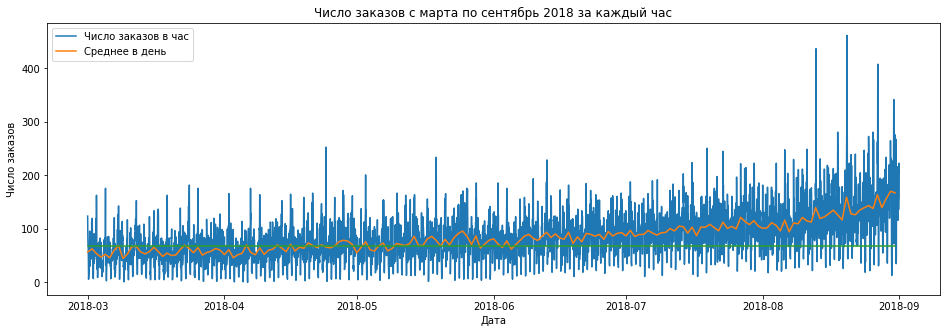

In [12]:
plt.figure(figsize=(16,5))
plt.plot(data_resampled['num_orders'])
plt.plot(data_resampled.groupby(pd.Grouper(key='date', freq='D')).mean())
plt.title('Число заказов с марта по сентябрь 2018 за каждый час')

plt.xlabel('Дата')
plt.ylabel('Число заказов')
plt.legend(['Число заказов в час', 'Среднее в день'])
plt.show()

Из графика выше сложно сделать вывод о цикличности ряда или тренде. На первый взгляд можно заметить слабый плавный тренд на повышение спроса на такси к концу периода, а также увеличение колебаний: в августе появились большие пики, превышающие отметку в 400 заказов в час. Более детельно компоненты ряда будут изучены далее, а для начала проверим, насколько данные за разные периоды зависимы друг от друга. Для этого построим график функции автокорреляции:

In [20]:
data_resampled

,num_orders,hour
datetime,,
2018-03-01 00:00:00,124,0
2018-03-01 01:00:00,85,6
2018-03-01 02:00:00,71,12
2018-03-01 03:00:00,66,18
2018-03-01 04:00:00,43,24
...,...,...
2018-08-31 19:00:00,136,114
2018-08-31 20:00:00,154,120
2018-08-31 21:00:00,159,126


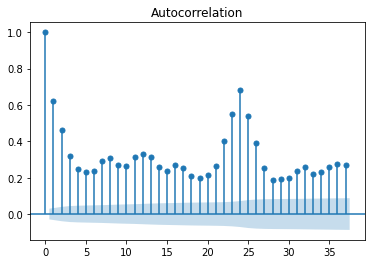

In [22]:
data_resampled = data.resample('1H').sum()
plot_acf(data_resampled)
plt.show()

На полученном графике видно, что все коэффициенты автокорреляции являются умеренно положительными. Кроме того, наблюдаются "всплески" коэффициентов: видно, что при лаге равном 2, а также 24, наблюдается корреляция выше 0.6, что вполне объяснимо: продажи можно предсказывать на основе данных за последний час, а также за последние сутки. Так как на коррелограмме не наблюдается затухания значений автокорроляции, можно сказать, что в течение суток нет тренда на изменение спроса. Чтобы точно убедиться в стационарности ряда, можно воспользоваться критерием Дики-Фулера, который проверяет гипотезу нестационарности ряда (нулевая гипотеза) против стационарности (альтернативная).

In [23]:
adfuller(data_resampled["num_orders"])

(-3.0689242890279647,
 0.028940051402612205,
 30,
 4385,
 {'1%': -3.431842162413052,
  '5%': -2.8621993540813637,
  '10%': -2.567120978470452},
 41728.71357827463)

При 5-% доверительном интервале критическое значение = -3.06 < -2.86. Следовательно, нулевая гипотеза отклоняется, ряд можно считать стационарным, преобразования не нужны.

In [24]:
decomposed = seasonal_decompose(data_resampled) 

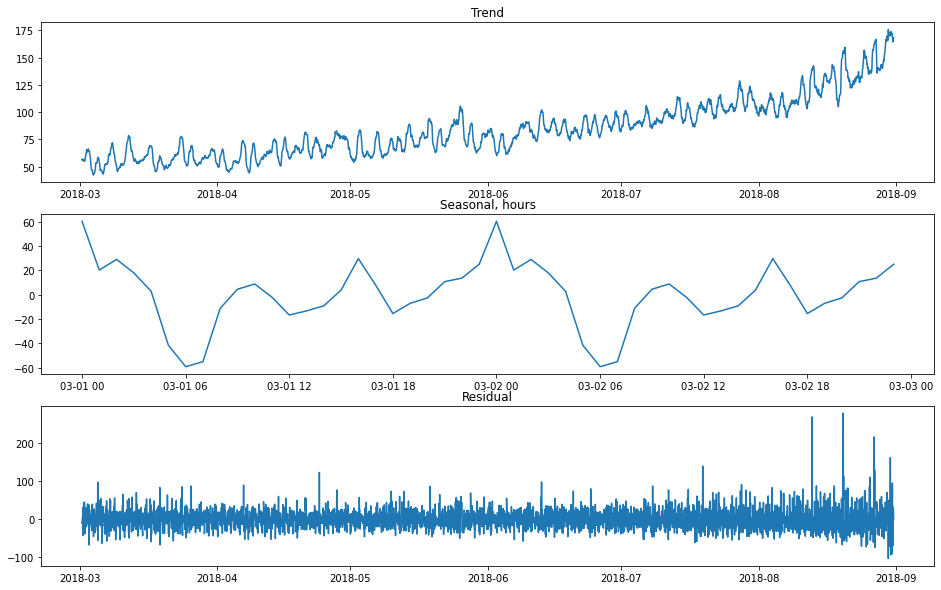

In [25]:
fig, axs = plt.subplots(3, figsize=(16,10), sharex=False)
axs[0].plot(decomposed.trend)
axs[0].set_title("Trend")

axs[1].plot(decomposed.seasonal['2018-03-01 00:00:00':'2018-03-02 23:00:00'])
axs[1].set_title("Seasonal, hours")


axs[2].plot(decomposed.resid)
axs[2].set_title("Residual")

plt.show()

## Обучение и тестирование модели

In [26]:
df = data_resampled.reset_index(drop=True)

In [27]:
df['t'] = np.arange(1, len(df)+1)/24

In [28]:
#разделим данные на тестовую (20%) и обучающую (80%) выборки
y_train, y_test = train_test_split(df.iloc[:, 0], test_size=0.2, shuffle=False)
X_train, X_test = train_test_split(df.t, test_size=0.2, shuffle=False)

#### Линейная модель

In [29]:
model = LinearRegression(fit_intercept = True)
model.fit(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1))
intercept = model.intercept_

preds_train = model.predict(np.array(X_train).reshape(-1, 1))
preds_test = model.predict(np.array(X_test).reshape(-1, 1))

In [30]:
residiuals = np.array(y_train) - np.ravel(preds_train)

RMSE на тестовой выборке: 57.059418398857005


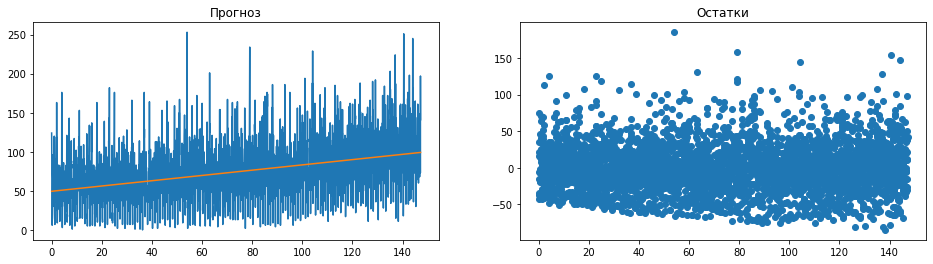

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(X_train, y_train)
ax1.plot(X_train, preds_train)
ax1.set_title('Прогноз')


ax2.scatter(np.array(X_train), residiuals)
ax2.set_title('Остатки')

print('RMSE на тестовой выборке:', np.sqrt(mean_squared_error(y_test, preds_test)))

Остатки не подчиняются какой либо функции, однако, ожидаемо, линейная регрессия плохо справилась с прогнозированием временного ряда, поэтому есть смысл попробовать другие модели.

#### Модель авторегрессии — скользящего среднего (Autoregressive–moving-average model, ARMA)

Создание признаков:

In [32]:
df_resample = data.resample("1H").sum()

In [33]:
def rmse(first_list, second_list):
    return np.sqrt(mean_squared_error(first_list, second_list))
    
def make_features(data, max_lag, rolling_mean_size):
    data = data.copy(deep=True)
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [34]:
best_rmse = 10**5
values = [i for i in range(1, 100)]
for p in [2, 24]:
    for q in values:
        data = make_features(df_resample, p, q)
        
        train, test = train_test_split(data, shuffle=False, test_size=0.1)
        train.dropna(inplace=True)
        
        X_train = train.drop("num_orders", axis=1)
        y_train = train["num_orders"]

        X_test = test.drop("num_orders", axis=1)
        y_test = test["num_orders"]
        
        lin_reg = LinearRegression()
        lin_reg.fit(X_train, y_train)

        preds = lin_reg.predict(X_train)
        
        current_rmse = rmse(preds, y_train)
        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_p = p
            best_q = q
print("RMSE:", best_rmse, "\nP:", best_p, "\nQ:", best_q)

RMSE: 25.59905548235161 
P: 24 
Q: 31


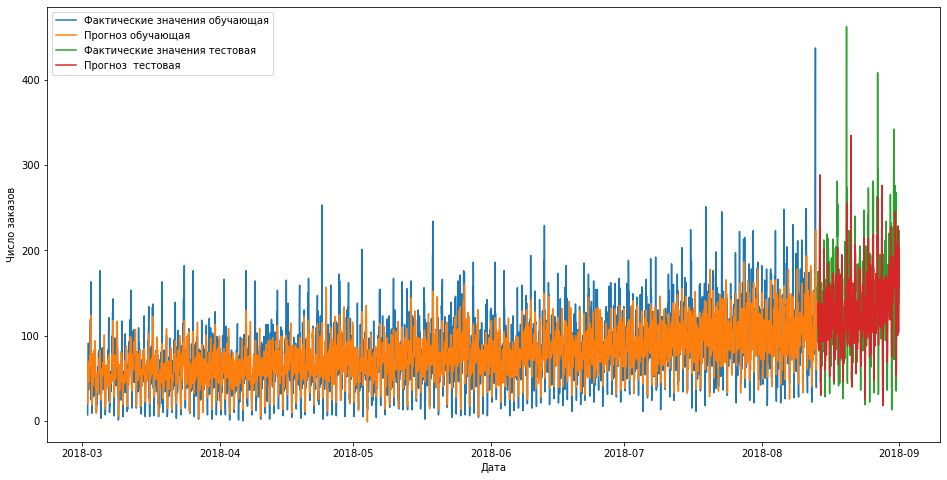

RMSE на тестовой выборке: 45.319


In [35]:
df_with_best_p_and_q = make_features(df_resample, best_p, best_q)

train, test = train_test_split(df_with_best_p_and_q, shuffle=False, test_size=0.1)
train.dropna(inplace=True)

X_train = train.drop("num_orders", axis=1)
y_train = train["num_orders"]

X_test = test.drop("num_orders", axis=1)
y_test = test["num_orders"]

model = LinearRegression().fit(X_train, y_train)
preds = model.predict(X_train)
preds_test = model.predict(X_test)

plt.figure(figsize=(16, 8))
plt.plot(X_train.index, y_train)
plt.plot(X_train.index, preds)

plt.plot(X_test.index, y_test)
plt.plot(X_test.index, preds_test)

plt.legend(['Фактические значения обучающая', 'Прогноз обучающая', 'Фактические значения тестовая', 'Прогноз  тестовая'])
plt.xlabel('Дата')
plt.ylabel('Число заказов')
plt.show()
print("RMSE на тестовой выборке:", round(rmse(preds_test, y_test), 3))

#### Вывод

В проекте было проанализированы данные по спросу на такси за каждые десть минут с марта по сентябрь 2018 года. В результате была составлена краткая характеристика спроса: пятница и понедельник отличаются наибольшим (общим и средним) числом заказов и выбросов. Также наиболее популярное время заказа - полночь и вечер (16-17 часов).  
Затем был проанализирован сам врменной ряд: он оказался монотонным и стационарным (согласно тесту Дики-Фуллера при 95% доверительном интервале). При построении графика функции автокорреляции обнаружилось, что данные больше всего коррелируются при лаге = 2 или 24. 
Для прогнозирования было составлено две модели: обычная линейная регрессия с единственным признаком - время t и ARMA. Вторая модель справилась проще, для нее были подобраны параметры: p (лаг) = 24, q (скользящее среднее) = 60. Прогноз на тестовой выборке показал значение RMSE = 45.043